Notebook created by Cem Daloglu & Enisa Sabo & Xin Wang 


Ullrich Köthe: Fundamentals of Machine Learning, Winter Semester 2021/22

---



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
import time

# **1 Nearest Neighbor Classification on Real Data**

# 1.1 Exploring the Data

In [3]:
digits = load_digits ()
print (digits . keys ())
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]
print (data.dtype)


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


In [4]:
print(images.shape)

(1797, 8, 8)


<Figure size 432x288 with 0 Axes>

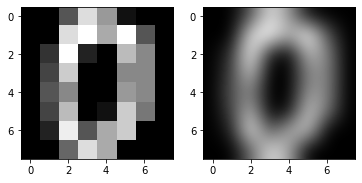

In [5]:
img = images[0]
assert 2 == len(img.shape)
plt.figure ()
plt.gray ()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img, interpolation ="nearest" )
axarr[1].imshow(img, interpolation ="bicubic")
plt.show ()

In [6]:
from sklearn import model_selection
X_all = data
y_all = target
X_train , X_test , y_train , y_test = model_selection.train_test_split(digits.data, digits.target, test_size = 0.4, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1078, 64) (719, 64) (1078,) (719,)


# 1.2 Distance function computation using loops

In [7]:
def dist_loop(training, test):
  dist_mat = np.zeros([len(training), len(test)])
  for n in range(len(training)):
    for m in range(len(test)):
      dist_mat[n][m] = np.sqrt(np.sum(np.square(training[n] - test[m])))
  return dist_mat

In [8]:
check = dist_loop(X_train,X_test)
print(check.shape)

(1078, 719)


# 1.3 Distance function computation using vectorization

In [9]:
def dist_vec(training, test):
  dist_mat = np.zeros([len(training), len(test)])
  trans_test = test.T
  mult_sets = -2 * (training @ trans_test)
  train_arr = np.sum(np.full((training.shape), np.square(training)), axis=1)
  test_arr = np.sum(np.full((test.shape), np.square(test)), axis=1)
  train_arr = np.resize(train_arr, mult_sets.T.shape).T
  test_arr = np.resize(test_arr, mult_sets.shape)
  dist_mat = np.sqrt(train_arr + test_arr + mult_sets)
  return dist_mat

In [10]:
check_vector = dist_vec(X_train,X_test)
print(check == check_vector)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [11]:
print("Run time vectorized:")
%timeit dist_vec(X_train,X_test)
print("Run time loop:")
%timeit dist_loop(X_train,X_test)

Run time vectorized:
20.6 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Run time loop:
6.4 s ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 1.4 Implement the k-nearest neighbor classifier

In [12]:
def nn_classifier(k, train_data, train_label, test_data):
    euc_dist = dist_vec(train_data, test_data).T
    idx = np.argpartition(euc_dist[0], k)
    labels = train_label[idx[:k]]
    return np.bincount(labels).argmax()

In [13]:
X_test_3 = X_test[np.argwhere(y_test == 3)]
X_train_3 = X_train[np.argwhere(y_train == 3)]
X_train_3.reshape((len(X_train_3), 64))
y_train_3 = y_train[np.argwhere(y_train == 3)]
y_test_3 = y_test[np.argwhere(y_test == 3)]

X_test_9 = X_test[np.argwhere(y_test == 9)]
X_train_9 = X_train[np.argwhere(y_train == 9)]
X_train_9.reshape((len(X_train_9), 64))
y_train_9 = y_train[np.argwhere(y_train == 9)]
y_test_9 = y_test[np.argwhere(y_test == 9)]

X_train_3_9 = np.append(X_train_3, X_train_9).reshape((len(X_train_3)+len(X_train_9), 64))
y_train_3_9 = np.append(y_train_3, y_train_9).astype(int)

In [14]:
def error_rate(k, train_data, train_label, test_data, test_label):
  count = 0
  for i in range(len(test_data)):
    if nn_classifier(k, train_data, train_label, test_data[i]) != test_label[i]:
      count += 1
  return [count / len(test_data)]

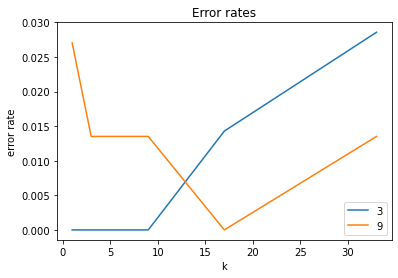

In [15]:
k = [1, 3, 5, 9, 17, 33]
error_3 = []
error_9 = []

for i in k:
  error_3.append(error_rate(i, X_train_3_9, y_train_3_9, X_test_3, y_test_3))
  error_9.append(error_rate(i, X_train_3_9, y_train_3_9, X_test_9, y_test_9))

plt.title("Error rates")
plt.errorbar(k, error_3, label="3")
plt.errorbar(k, error_9, label="9")
plt.xlabel("k")
plt.ylabel("error rate")
plt.legend()
plt.show()

As k (number of neigbhors) increases error rate is also increased for "3". However, error rate is decreased until k = 17 for digit "9". We can say that too much neighbor increases the error and error rate is dependent to digit. By only looking at the above plot, best possible k can be approximately 12 or 13.

# 2 Cross-validation

In [16]:
def split_folds(data, target, L):
    X_folds = []
    Y_folds = []
    permutations = np.array_split(np.random.permutation(np.shape(data)[0]),L)
    
    for i in permutations:
        X_folds.append(data[i])
        Y_folds.append(target[i])

    return X_folds, Y_folds

In [17]:
def splitter(i, X_folds, Y_folds):
  index = np.zeros(len(X_folds)+1, int)
  for ind in range(len(X_folds)-1):
    shallow_x = np.array([*X_folds[ind], *X_folds[ind+1]])
    shallow_y = np.array([*Y_folds[ind], *Y_folds[ind+1]])
    index[ind+1] = len(X_folds[ind])
  index[len(index)-1] = len(shallow_x)
  
  X_test = X_folds[i]
  y_test = Y_folds[i]
  X_test = np.reshape(X_test, (len(X_test), 1, 64))
  
  X_train = np.array([*shallow_x[:index[i]], *shallow_x[index[i+1]:]])
  y_train = np.array([*shallow_y[:index[i]], *shallow_y[index[i+1]:]])
  return X_train, y_train, X_test, y_test

In [18]:
k = [1, 17]
L = [2, 5, 10]
error_k = []
std_k = []
error_L = []
error_j = []
std_j = []

start_knn = time.time()

for i in k:
  error_L = []
  for j in L:
    X_folds, Y_folds = split_folds(data, target, j)
    error_j = []
    for x in range(j):
      X_train, y_train, X_test, y_test = splitter(x, X_folds, Y_folds)

      error_j.append(error_rate(i, X_train, y_train, X_test, y_test))
    std_j.append([np.std(error_j)])
    error_L.append([np.average(error_j)])
  error_k.append(error_L)
  std_k.append(std_j)
end_knn = time.time()

In [19]:
def plotter(error_k, std_k):
  error_k1_L2 = error_k[0][0]
  error_k1_L5 = error_k[0][1]
  error_k1_L10 = error_k[0][2]
  error_k17_L2 = error_k[1][0]
  error_k17_L5 = error_k[1][1]
  error_k17_L10 = error_k[1][2]

  plt.title("Error rates")
  plt.xlabel("L")
  plt.ylabel("error rate")
  plt.plot(L, [*error_k1_L2, *error_k1_L5, *error_k1_L10], label="k=1")
  plt.plot(L, [*error_k17_L2, *error_k17_L5, *error_k17_L10], label="k=17")
  plt.legend()

  std_k1_L2 = std_k[0][0]
  std_k1_L5 = std_k[0][1]
  std_k1_L10 = std_k[0][2]
  std_k17_L2 = std_k[1][0]
  std_k17_L5 = std_k[1][1]
  std_k17_L10 = std_k[1][2]
  print("standard deviation of k=1, L=2", std_k1_L2)
  print("standard deviation of k=1, L=5", std_k1_L5)
  print("standard deviation of k=1, L=10", std_k1_L10)
  print("standard deviation of k=17, L=2", std_k17_L2)
  print("standard deviation of k=17, L=5", std_k17_L5)
  print("standard deviation of k=17, L=10", std_k17_L10)

standard deviation of k=1, L=2 [1.0528897488176758e-05]
standard deviation of k=1, L=5 [0.01840648348605842]
standard deviation of k=1, L=10 [0.021958016986549967]
standard deviation of k=17, L=2 [1.0528897488176758e-05]
standard deviation of k=17, L=5 [0.01840648348605842]
standard deviation of k=17, L=10 [0.021958016986549967]


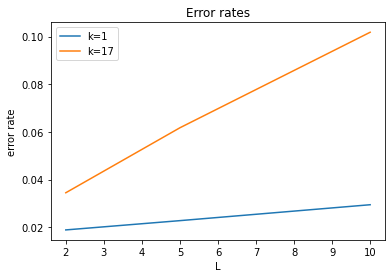

In [20]:
plotter(error_k, std_k)

In [21]:
def error_rate_sklearn(test_label,y_test):
    error = 0
    for i in range(test_label.shape[0]):
        if test_label[i]!=y_test[i]:
            error += 1
    return error/(len(test_label))

In [22]:
k = [1, 17]
L = [2, 5, 10]
result_j = []
result_L = []
result_k = []
std_j = []
std_k = []

start_sklearn = time.time()

for i in k:
  result_L = []
  for j in L:
    X_folds, Y_folds = split_folds(data, target, j)
    result_j = []
    for x in range(j):
      X_train, y_train, X_test, y_test = splitter(x, X_folds, Y_folds)

      X_test = np.reshape(X_test, (len(X_test), 64))
      neigh = KNeighborsClassifier(n_neighbors=i)
      neigh.fit(X_train, y_train)
      test_label = neigh.predict(X_test)
      result_j.append(error_rate_sklearn(test_label, y_test))
    std_j.append([np.std(result_j)])
    result_L.append([np.average(result_j)])
  result_k.append(result_L)
  std_k.append(std_j)
end_sklearn = time.time()

standard deviation of k=1, L=2 [0.002793254568922163]
standard deviation of k=1, L=5 [0.013380219289381427]
standard deviation of k=1, L=10 [0.02016804315366065]
standard deviation of k=17, L=2 [0.002793254568922163]
standard deviation of k=17, L=5 [0.013380219289381427]
standard deviation of k=17, L=10 [0.02016804315366065]


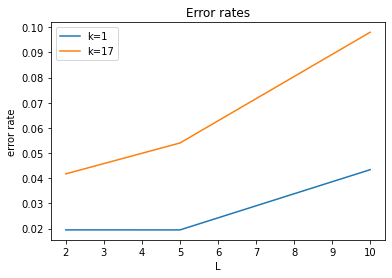

In [23]:
plotter(result_k, std_k)

In [24]:
print("Run time sklearn:", (end_sklearn - start_sklearn), "seconds")
print("Run time knn_first_part:", (end_knn - start_knn), "seconds")

Run time sklearn: 0.5207424163818359 seconds
Run time knn_first_part: 5.461919069290161 seconds


As it can be seen in the above results, performance of the predefined solution is much faster than our solution. As L increases the error rate also increases. Therefore, it can be generalized that smaller L are better than larger L values in terms of error rate.